In [8]:
import numpy as np 
import pandas as pd
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Reshape

In [9]:
conv_base = VGG16(weights = "imagenet",
                  include_top = False,
                  input_shape = (256,256,3)
                  )

In [10]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in conv_base.layers:
    print(layer.name, layer.trainable)
    

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Reshape

# Assuming conv_base is defined (e.g., a pretrained model)
model = Sequential()

# Add the convolutional base
model.add(conv_base)

# Flatten the output
model.add(Flatten())

# Modify the Dense layer to fit LSTM requirements
model.add(Dense(10 * 128, activation='relu'))  # 10 timesteps, 128 features
model.add(Dropout(0.25))

# Reshape to (batch_size, timesteps, features)
model.add(Reshape((10, 128)))  # Now this will work

# Add LSTM layer
model.add(LSTM(64, return_sequences=True))  # Set return_sequences=False if it's the last LSTM layer

# Add additional layers as needed
model.add(Flatten())  # Flatten again after LSTM if needed
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))


In [15]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 1280)              41944320  
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 reshape_2 (Reshape)         (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 flatten_7 (Flatten)         (None, 640)              

In [16]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'output/train/',
    labels = 'inferred',
    label_mode = 'int',
    # color_mode = 'grayscale',
    batch_size = 32,
    image_size = (256,256)
)

Found 4200 files belonging to 2 classes.


In [17]:
validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'output/val/',
    labels = 'inferred',
    label_mode = 'int',
    # color_mode = 'grayscale',
    batch_size = 32,
    image_size = (256,256)
)

Found 1200 files belonging to 2 classes.


In [18]:
testing_ds = keras.utils.image_dataset_from_directory(
    directory = 'output/test/',
    labels = 'inferred',
    label_mode = 'int',
    # color_mode = 'grayscale',
    batch_size = 32,
    image_size = (256,256)
)

Found 600 files belonging to 2 classes.


In [19]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [20]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [21]:
#

In [22]:
def process(image, label):
  image = tensorflow.cast(image/255. , tensorflow.float32)
  return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [23]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-5),
    loss = 'binary_crossentropy',
    metrics=METRICS
    )

In [24]:
history = model.fit(train_ds, epochs = 40, validation_data= validation_ds)

Epoch 1/40
132/132 [==============================] - 1869s 14s/step - loss: 0.6887 - accuracy: 0.5376 - precision: 0.5353 - recall: 0.5700 - auc: 0.5531 - val_loss: 0.6719 - val_accuracy: 0.5717 - val_precision: 0.6361 - val_recall: 0.3350 - val_auc: 0.6452
Epoch 2/40
132/132 [==============================] - 1823s 14s/step - loss: 0.6676 - accuracy: 0.5912 - precision: 0.5838 - recall: 0.6352 - auc: 0.6271 - val_loss: 0.6667 - val_accuracy: 0.5758 - val_precision: 0.6667 - val_recall: 0.3033 - val_auc: 0.6573
Epoch 3/40
132/132 [==============================] - 1826s 14s/step - loss: 0.6521 - accuracy: 0.6060 - precision: 0.5913 - recall: 0.6862 - auc: 0.6484 - val_loss: 0.6539 - val_accuracy: 0.6058 - val_precision: 0.6389 - val_recall: 0.4867 - val_auc: 0.6628
Epoch 4/40
132/132 [==============================] - 1821s 14s/step - loss: 0.6445 - accuracy: 0.6160 - precision: 0.6007 - recall: 0.6914 - auc: 0.6658 - val_loss: 0.6453 - val_accuracy: 0.6117 - val_precision: 0.6136 - v

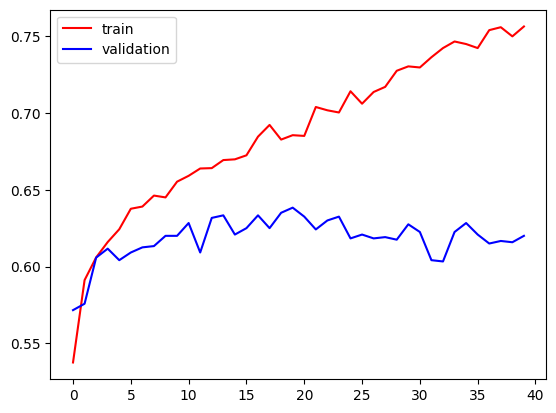

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

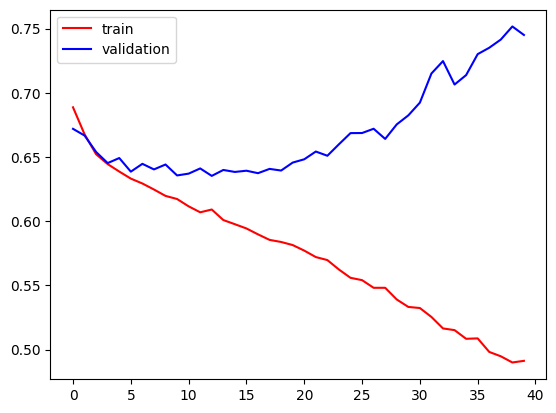

In [26]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

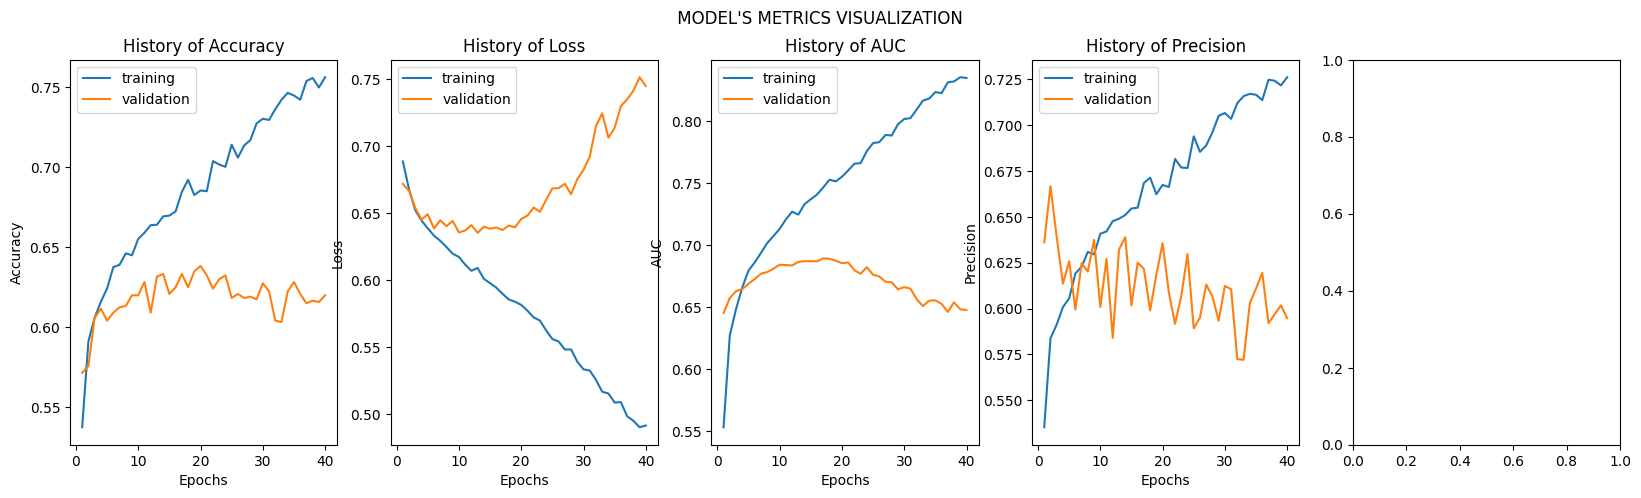

In [27]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    '''
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])
    '''

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']
               #history.history['f1_score'],history.history['val_f1_score']
              )

In [28]:
score = model.evaluate(testing_ds, verbose = 1) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

19/19 [==============================] - 170s 9s/step - loss: 1.6310 - accuracy: 0.5717 - precision: 0.6215 - recall: 0.3667 - auc: 0.6065
Test loss: 1.6309691667556763
Test accuracy: 0.5716666579246521


In [29]:
predictions = model.predict(testing_ds,verbose=1)
import numpy as np
class_index = 2
pred = predictions.argmax(axis=1)
print(pred)

19/19 [==============================] - 172s 9s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [30]:
model.save('modelfinal32.h5')

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
